#Setup

In [ ]:
!git clone https://github.com/baoguangsheng/fast-detect-gpt.git

Cloning into 'fast-detect-gpt'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 762 (delta 240), reused 209 (delta 209), pack-reused 498 (from 1)
Receiving objects: 100% (762/762), 226.69 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (574/574), done.
Updating files: 100% (503/503), done.


In [ ]:
%cd fast-detect-gpt

/content/fast-detect-gpt


In [ ]:
!pip install torch numpy transformers datasets matplotlib tqdm openai nltk

In [ ]:
%%writefile scripts/local_infer.py
# Copyright (c) Guangsheng Bao.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
import random
import numpy as np
import torch
import os
import glob
import argparse
import json
from model import load_tokenizer, load_model
from fast_detect_gpt import get_sampling_discrepancy_analytic
from scipy.stats import norm

# Considering balanced classification that p(D0) equals to p(D1), we have
# p(D1|x) = p(x|D1) / (p(x|D1) + p(x|D0))
def compute_prob_norm(x, mu0, sigma0, mu1, sigma1):
    pdf_value0 = norm.pdf(x, loc=mu0, scale=sigma0)
    pdf_value1 = norm.pdf(x, loc=mu1, scale=sigma1)
    prob = pdf_value1 / (pdf_value0 + pdf_value1)
    return prob

class FastDetectGPT:
    def __init__(self, args):
        self.args = args
        self.criterion_fn = get_sampling_discrepancy_analytic
        self.scoring_tokenizer = load_tokenizer(args.scoring_model_name, args.cache_dir)
        self.scoring_model = load_model(args.scoring_model_name, args.device, args.cache_dir)
        self.scoring_model.eval()
        if args.sampling_model_name != args.scoring_model_name:
            self.sampling_tokenizer = load_tokenizer(args.sampling_model_name, args.cache_dir)
            self.sampling_model = load_model(args.sampling_model_name, args.device, args.cache_dir)
            self.sampling_model.eval()

        distrib_params = {
            'gpt-j-6B_gpt-neo-2.7B': {'mu0': 0.2713, 'sigma0': 0.9366, 'mu1': 2.2334, 'sigma1': 1.8731},
            'gpt-neo-2.7B_gpt-neo-2.7B': {'mu0': -0.2489, 'sigma0': 0.9968, 'mu1': 1.8983, 'sigma1': 1.9935},
            'falcon-7b_falcon-7b-instruct': {'mu0': -0.0707, 'sigma0': 0.9520, 'mu1': 2.9306, 'sigma1': 1.9039},
        }
        key = f'{args.sampling_model_name}_{args.scoring_model_name}'

        # Fallback for KeyError
        if key not in distrib_params:
            print(f"Warning: Key '{key}' not in distrib_params. Using 'gpt-neo-2.7B_gpt-neo-2.7B' as fallback.")
            key = 'gpt-neo-2.7B_gpt-neo-2.7B'

        self.classifier = distrib_params[key]

    # compute conditional probability curvature
    def compute_crit(self, text):
        tokenized = self.scoring_tokenizer(text, truncation=True, return_tensors="pt", padding=True, return_token_type_ids=False).to(self.args.device)
        labels = tokenized.input_ids[:, 1:]
        if labels.size(1) == 0: # Handle empty or single-token text
            return float('nan'), 0
        with torch.no_grad():
            logits_score = self.scoring_model(**tokenized).logits[:, :-1]
            if self.args.sampling_model_name == self.args.scoring_model_name:
                logits_ref = logits_score
            else:
                tokenized = self.sampling_tokenizer(text, truncation=True, return_tensors="pt", padding=True, return_token_type_ids=False).to(self.args.device)
                assert torch.all(tokenized.input_ids[:, 1:] == labels), "Tokenizer is mismatch."
                logits_ref = self.sampling_model(**tokenized).logits[:, :-1]
            crit = self.criterion_fn(logits_ref, logits_score, labels)
        return crit, labels.size(1)

    # compute probability
    def compute_prob(self, text):
        crit, ntoken = self.compute_crit(text)
        if np.isnan(crit):
            return float('nan'), crit, ntoken
        mu0 = self.classifier['mu0']
        sigma0 = self.classifier['sigma0']
        mu1 = self.classifier['mu1']
        sigma1 = self.classifier['sigma1']
        prob = compute_prob_norm(crit, mu0, sigma0, mu1, sigma1)
        return prob, crit, ntoken

# --- NEW FLEXIBLE MAIN BLOCK ---
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # --- Text argument is now OPTIONAL ---
    parser.add_argument('--text', type=str, default=None, help='(Optional) Text to be analyzed.')
    parser.add_argument('--sampling_model_name', type=str, default="gpt-neo-2.7B")
    parser.add_argument('--scoring_model_name', type=str, default="gpt-neo-2.7B")
    parser.add_argument('--device', type=str, default="cuda")
    parser.add_argument('--cache_dir', type=str, default="../cache")
    args = parser.parse_args()

    # --- EDIT THIS VARIABLE TO TEST YOUR TEXT ---

    default_text_to_analyze = """
    i am human
"""

    # Check if --text argument was provided
    if args.text is not None:
      text_to_analyze = args.text
      print("Using text provided from command line.")
    else:
      text_to_analyze = default_text_to_analyze
      print("No --text argument found. Using default text from script.")

    # 1. Initialize the detector
    print("Initializing detector...")
    detector = FastDetectGPT(args)
    print("Detector initialized.")

    # 2. Estimate the probability
    print(f"\nAnalyzing text: '{text_to_analyze.strip()[:100]}...'")
    prob, crit, ntokens = detector.compute_prob(text_to_analyze)

    # 3. Print the result
    print(f'\n--- Result ---')
    if np.isnan(crit):
        print(f'Could not analyze text. It might be too short or invalid.')
    else:
        print(f'Fast-DetectGPT criterion is {crit:.4f}')
        print(f'Probability of being machine-generated: {prob * 100:.0f}%')

Overwriting scripts/local_infer.py


In [ ]:
!python scripts/local_infer.py \
    --scoring_model_name gpt-neo-2.7B \
    --sampling_model_name gpt-neo-2.7B \
    --text "This second script is not DetectGPT and not the original Fast-DetectGPT paper method either — but it is a custom simplified Fast-DetectGPT-style heuristic, built on top of the analytic discrepancy function from your earlier code." \
    --device cuda

Using text provided from command line.
Initializing detector...
tokenizer_config.json: 100% 200/200 [00:00<00:00, 1.87MB/s]
config.json: 1.46kB [00:00, 8.19MB/s]
vocab.json: 798kB [00:00, 83.7MB/s]
merges.txt: 456kB [00:00, 102MB/s]
special_tokens_map.json: 100% 90.0/90.0 [00:00<00:00, 162kB/s]
Loading model EleutherAI/gpt-neo-2.7B...
`torch_dtype` is deprecated! Use `dtype` instead!
2025-11-27 22:20:03.757898: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 22:20:03.775186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764282003.796588    7532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to regis

#Baseline

In [ ]:
!mkdir -p baseline/exp_gpt3to4/results/

In [ ]:
# Run Fast-DetectGPT with GPT-Neo-2.7B (fits in Colab)
# Using black-box setting: sampling and scoring with surrogate models

dataset = "xsum"
source_model = "gpt-3.5-turbo"  # The model that generated the text
sampling_model = "gpt-neo-2.7B"  # Surrogate model for sampling
scoring_model = "gpt-neo-2.7B"   # Surrogate model for scoring

!python scripts/fast_detect_gpt.py \
    --sampling_model_name {sampling_model} \
    --scoring_model_name {scoring_model} \
    --dataset {dataset} \
    --dataset_file exp_gpt3to4/data/{dataset}_{source_model} \
    --output_file exp_gpt3to4/results/{dataset}_{source_model}.{sampling_model}_{scoring_model}

Traceback (most recent call last):
  File "/content/fast-detect-gpt/scripts/fast_detect_gpt.py", line 162, in <module>
    experiment(args)
  File "/content/fast-detect-gpt/scripts/fast_detect_gpt.py", line 74, in experiment
    scoring_tokenizer = load_tokenizer(args.scoring_model_name, args.dataset, args.cache_dir)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: load_tokenizer() takes 2 positional arguments but 3 were given


In [ ]:
# Quick Fix for Tokenizer Loading Issue
import re
import os

def fix_tokenizer_calls():
    """Fix the load_tokenizer function calls"""

    files_to_fix = [
        'scripts/fast_detect_gpt.py',
        'scripts/baselines.py',
        'scripts/detect_gpt.py',
        'scripts/detect_llm.py',
    ]

    for filepath in files_to_fix:
        if not os.path.exists(filepath):
            continue

        with open(filepath, 'r') as f:
            content = f.read()

        old_pattern = r'load_tokenizer\(([^,]+),\s*args\.dataset,\s*([^)]+)\)'
        if not re.search(old_pattern, content):
            continue

        # Create backup
        with open(filepath + '.backup', 'w') as f:
            f.write(content)

        # Apply fix
        fixed_content = re.sub(
            r'load_tokenizer\(([^,]+),\s*args\.dataset,\s*([^)]+)\)',
            r'load_tokenizer(\1, \2)',
            content
        )

        with open(filepath, 'w') as f:
            f.write(fixed_content)

        print(f"✓ Fixed: {filepath}")

    print("\n✓ Fix applied!")

fix_tokenizer_calls()

✓ Fixed: scripts/fast_detect_gpt.py

✓ Fix applied!


In [ ]:
dataset = "xsum"
source_model = "gpt-3.5-turbo"  # The model that generated the text
sampling_model = "gpt-neo-2.7B"  # Surrogate model for sampling
scoring_model = "gpt-neo-2.7B"   # Surrogate model for scoring

!python scripts/fast_detect_gpt.py \
    --sampling_model_name {sampling_model} \
    --scoring_model_name {scoring_model} \
    --dataset {dataset} \
    --dataset_file exp_gpt3to4/data/{dataset}_{source_model} \
    --output_file baseline/exp_gpt3to4/results/{dataset}_{source_model}.{sampling_model}_{scoring_model}

Loading model EleutherAI/gpt-neo-2.7B...
`torch_dtype` is deprecated! Use `dtype` instead!
2025-11-27 22:21:22.346733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 22:21:22.365371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764282082.387309    8046 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764282082.393992    8046 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764282082.411696    8046 computation_pl

## performance summarization function

In [ ]:
import json
import numpy as np
import os

def summarize_performance(json_file_path):
    """
    Loads a JSON experiment file from fast-detect-gpt, calculates performance
    statistics, and prints a formatted summary.

    Args:
        json_file_path (str): The file path to the experiment's JSON output file.
    """

    # Check if the file exists
    if not os.path.exists(json_file_path):
        print(f"Error: The file '{json_file_path}' was not found.")
        return

    try:
        # Open and load the JSON data
        with open(json_file_path, 'r') as f:
            data = json.load(f)

        # --- Extract Metadata ---
        test_name = data.get('name', 'N/A')
        n_samples = data.get('info', {}).get('n_samples', 'N/A')

        # --- Extract Final Metrics ---
        roc_auc = data.get('metrics', {}).get('roc_auc', 'N/A')
        pr_auc = data.get('pr_metrics', {}).get('pr_auc', 'N/A')

        # --- Extract and Calculate Prediction Statistics ---
        predictions = data.get('predictions', {})
        real_scores = predictions.get('real', [])
        sampled_scores = predictions.get('samples', [])

        # Calculate mean and std dev for human ("real") scores
        if real_scores:
            real_mean = np.mean(real_scores)
            real_std = np.std(real_scores)
        else:
            real_mean = 'N/A'
            real_std = 'N/A'

        # Calculate mean and std dev for machine ("sampled") scores
        if sampled_scores:
            sampled_mean = np.mean(sampled_scores)
            sampled_std = np.std(sampled_scores)
        else:
            sampled_mean = 'N/A'
            sampled_std = 'N/A'

        # --- Print the Summary Report ---
        print(f"--- Performance Summary for: {os.path.basename(json_file_path)} ---")
        print(f"Test Name: {test_name}")
        print(f"Number of Samples: {n_samples}")
        print("\n--- Prediction Scores (Criterion) ---")

        # Print real scores statistics
        if isinstance(real_mean, float):
            print(f"Human (Real) Scores Mean: {real_mean:.4f}")
            print(f"Human (Real) Scores Std Dev: {real_std:.4f}")
        else:
            print("Human (Real) Scores Mean: N/A")
            print("Human (Real) Scores Std Dev: N/A")

        # Print sampled scores statistics
        if isinstance(sampled_mean, float):
            print(f"Machine (Sampled) Scores Mean: {sampled_mean:.4f}")
            print(f"Machine (Sampled) Scores Std Dev: {sampled_std:.4f}")
        else:
            print("Machine (Sampled) Scores Mean: N/A")
            print("Machine (Sampled) Scores Std Dev: N/A")

        print("\n--- Key Metrics ---")

        # Print final metrics
        if isinstance(roc_auc, float):
            print(f"ROC AUC: {roc_auc:.4f}")
        else:
            print("ROC AUC: N/A")

        if isinstance(pr_auc, float):
            print(f"PR AUC: {pr_auc:.4f}")
        else:
            print("PR AUC: N/A")

        print("-------------------------------------------------" + "-" * len(os.path.basename(json_file_path)))

    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from the file '{json_file_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")



In [ ]:
file_path = './baseline/exp_gpt3to4/results/xsum_gpt-3.5-turbo.gpt-neo-2.7B_gpt-neo-2.7B.sampling_discrepancy.json'

summarize_performance(file_path)

--- Performance Summary for: xsum_gpt-3.5-turbo.gpt-neo-2.7B_gpt-neo-2.7B.sampling_discrepancy.json ---
Test Name: sampling_discrepancy_threshold
Number of Samples: 150

--- Prediction Scores (Criterion) ---
Human (Real) Scores Mean: -0.0941
Human (Real) Scores Std Dev: 1.0351
Machine (Sampled) Scores Mean: 3.0240
Machine (Sampled) Scores Std Dev: 0.8012

--- Key Metrics ---
ROC AUC: 0.9920
PR AUC: 0.9930
-----------------------------------------------------------------------------------------------------------------------


#All Attacks

### Synonym Attacks

In [ ]:
import json
import nltk
from nltk.corpus import wordnet
import random
from pathlib import Path

# Download required NLTK data (updated for newer NLTK versions)
nltk.download('punkt')
nltk.download('punkt_tab')  # Added for newer NLTK
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # Added for newer NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_wordnet_pos(treebank_tag):
    """Convert Penn Treebank POS to WordNet POS"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def get_synonyms(word, pos):
    """Get WordNet synonyms for a word"""
    synonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_attack(text, replacement_rate=0.1):
    """Replace 10% of tokens with synonyms"""
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Target content words (nouns, verbs, adjectives)
    content_word_indices = [
        i for i, (word, pos) in enumerate(pos_tags)
        if pos.startswith(('NN', 'VB', 'JJ')) and word.isalpha()
    ]

    # Calculate exact number to replace based on total tokens
    num_to_replace = int(len(tokens) * replacement_rate)

    if not content_word_indices:
        return text, 0

    # Select random content words to replace
    indices_to_replace = random.sample(
        content_word_indices,
        min(num_to_replace, len(content_word_indices))
    )

    modified_tokens = tokens.copy()
    replacements_made = 0

    for idx in indices_to_replace:
        word, pos = pos_tags[idx]
        wn_pos = get_wordnet_pos(pos)
        synonyms = get_synonyms(word, wn_pos)

        if synonyms:
            modified_tokens[idx] = random.choice(synonyms)
            replacements_made += 1

    # Reconstruct text (simple join - may need refinement for punctuation)
    result = ' '.join(modified_tokens)
    # Fix common spacing issues
    result = result.replace(' .', '.').replace(' ,', ',').replace(' !', '!').replace(' ?', '?')

    return result, replacements_made

def strategic_perturbation_attack(text, replacement_rate=0.1):
    """
    Replace common function words and determiners
    These often don't change meaning much but affect probability
    """
    tokens = nltk.word_tokenize(text)

    # Substitution dictionary
    substitutions = {
        'the': ['a', 'this', 'that'],
        'a': ['the', 'one'],
        'an': ['a', 'the'],
        'is': ['was', 'seems', 'appears'],
        'are': ['were', 'seem'],
        'was': ['is', 'seemed'],
        'were': ['are', 'seemed'],
        'very': ['quite', 'really', 'extremely'],
        'said': ['stated', 'mentioned', 'noted'],
        'also': ['additionally', 'furthermore', 'moreover'],
        'however': ['but', 'nevertheless', 'yet'],
        'therefore': ['thus', 'hence', 'consequently'],
    }

    num_to_replace = int(len(tokens) * replacement_rate)
    modified_tokens = tokens.copy()
    replacements = 0

    # Randomly shuffle indices to replace
    replaceable_indices = [
        i for i, token in enumerate(tokens)
        if token.lower() in substitutions
    ]
    random.shuffle(replaceable_indices)

    for idx in replaceable_indices[:num_to_replace]:
        token = tokens[idx]
        token_lower = token.lower()

        if token_lower in substitutions:
            replacement = random.choice(substitutions[token_lower])
            # Preserve capitalization
            if token[0].isupper():
                replacement = replacement.capitalize()
            modified_tokens[idx] = replacement
            replacements += 1

    result = ' '.join(modified_tokens)
    result = result.replace(' .', '.').replace(' ,', ',').replace(' !', '!').replace(' ?', '?')

    return result, replacements

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Paraphrase Attacks

In [ ]:
from huggingface_hub import login
login(new_session=False)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import gc
import nltk
import random

pipe = None
LLAMA_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
_tokenizer = None
_model = None

In [ ]:
def get_llama_model():
    global _tokenizer, _model

    if _tokenizer is not None and _model is not None:
        return _tokenizer, _model

    print("Loading Llama model once...")

    _tokenizer = AutoTokenizer.from_pretrained(LLAMA_MODEL, padding_side="left")
    _tokenizer.pad_token = _tokenizer.eos_token

    _model = AutoModelForCausalLM.from_pretrained(
        LLAMA_MODEL,
        device_map="cuda",
    )

    _model.eval()
    return _tokenizer, _model

def unload_llama():
    global _tokenizer, _model
    del _tokenizer
    del _model
    _tokenizer = None
    _model = None
    gc.collect()
    torch.cuda.empty_cache()

def build_chat_batch(sentences, tokenizer):
    prompts = []

    for sentence in sentences:
        messages = [
            {
                "role": "system",
                "content": (
                    "You rewrite sentences in a casual, natural, human way. Avoid AI-like phrasing. "
                    "You rewrite ONLY the user’s sentence. "
                    "Do not ask questions. Do not respond conversationally. Output ONLY the rewritten sentence, nothing more."
                ),
            },
            {
                "role": "user",
                "content": sentence,
            },
        ]

        # Apply template to ONE conversation at a time
        prompt = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False
        )
        prompts.append(prompt)

    # Now batch tokenize all prompts
    encoded = tokenizer(
        prompts,
        return_tensors="pt",
        truncation=True,
        padding=True,
    )

    return encoded


def extract_assistant_response(text):
    # Llama 3 / Meta chat template — last assistant header
    if "<|start_header_id|>assistant<|end_header_id|>" in text:
        text = text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()

    # Fallback: split on literal "assistant\n\n"
    elif "assistant" in text:
        parts = text.split("assistant")
        text = parts[-1].strip()

    # Remove stray template tokens
    for bad in ["<|eot_id|>", "<|start_header_id|>", "<|end_header_id|>"]:
        text = text.replace(bad, "").strip()

    return text


def paraphrase_batch(sentences, max_new_tokens=60):
    tokenizer, model = get_llama_model()

    inputs = build_chat_batch(sentences, tokenizer).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode entire batch
    batch_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    results = []
    for text in batch_text:
        clean = extract_assistant_response(text)
        results.append(clean)

    return results


# count changed token by longest similar subsequence
import difflib
def count_token_replacements(original, paraphrased):
    orig_tokens = nltk.word_tokenize(original)
    para_tokens = nltk.word_tokenize(paraphrased)

    matcher = difflib.SequenceMatcher(None, orig_tokens, para_tokens)

    replaced = 0
    for opcode, a0, a1, b0, b1 in matcher.get_opcodes():
        if opcode in ("replace", "delete", "insert"):
            replaced += max(a1 - a0, b1 - b0)
    return replaced

def paraphrase_attack_llama(text, replacement_rate=0.1, batch_size=8):

    nltk.download("punkt", quiet=True)
    sentences = nltk.sent_tokenize(text)

    n_total = len(sentences)
    n_replace = max(1, int(n_total * replacement_rate))

    indices = set(random.sample(range(n_total), n_replace))

    to_paraphrase = []
    positions = []

    # Collect sentences to paraphrase
    for i, sent in enumerate(sentences):
        if i in indices:
            to_paraphrase.append(sent)
            positions.append(i)

    # Batch paraphrase
    new_sentences = paraphrase_batch(to_paraphrase)

    # Insert results back
    replacements_made = 0
    out_sentences = sentences.copy()

    for pos, old, new in zip(positions, to_paraphrase, new_sentences):
        out_sentences[pos] = new
        replacements_made += count_token_replacements(old, new)

    return " ".join(out_sentences), replacements_made

text = "The cat sat on the mat. The weather is bad. I can clean up your entire script into a ready-to-run file."
paraphrased_text = paraphrase_attack_llama(text, replacement_rate = 1)
print(text)
print(paraphrased_text)


Loading Llama model once...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

The cat sat on the mat. The weather is bad. I can clean up your entire script into a ready-to-run file.
("The cat sat on the mat. It's really not looking great outside. I can clean up your entire script into a ready-to-run file.", 7)


In [ ]:
text = "The cat sat on the mat. Just tell me and I’ll adapt it. I can clean up your entire script into a ready-to-run file."
paraphrased_text = paraphrase_attack_llama(text, replacement_rate = 0.5)
print(text)
print(paraphrased_text)

The cat sat on the mat. Just tell me and I’ll adapt it. I can clean up your entire script into a ready-to-run file.
('The cat was sitting on the mat. Just tell me and I’ll adapt it. I can clean up your entire script into a ready-to-run file.', 2)


In [ ]:
unload_llama()

### Apply Attacks

In [ ]:
def apply_attack_to_dataset(
    input_file,
    output_file,
    attack_function,
    replacement_rate=0.1
):
    """
    Apply attack to Fast-DetectGPT dataset (raw_data.json format)
    """
    # Load dataset
    with open(input_file, 'r') as f:
        dataset = json.load(f)

    attacked_dataset = {
        'sampled': [],
        'original': dataset.get('original', [])
    }

    stats = {
        'total_samples': 0,
        'total_tokens_original': 0,
        'total_tokens_replaced': 0,
        'successful_attacks': 0
    }

    from tqdm import tqdm
    for original_text in tqdm(dataset['sampled'], desc="Applying attack", unit="sample"):
        # Apply attack
        attacked_text, num_replaced = attack_function(
            original_text,
            replacement_rate
        )

        attacked_dataset['sampled'].append(attacked_text)

        # Track statistics
        original_tokens = len(nltk.word_tokenize(original_text))
        stats['total_samples'] += 1
        stats['total_tokens_original'] += original_tokens
        stats['total_tokens_replaced'] += num_replaced
        if num_replaced > 0:
            stats['successful_attacks'] += 1

    # Save attacked dataset
    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as f:
        json.dump(attacked_dataset, f, indent=2)

    # Print statistics
    print(f"✓ Attacked dataset saved to {output_file}")
    print(f"\n=== Attack Statistics ===")
    print(f"Total samples processed: {stats['total_samples']}")
    print(f"Successful attacks: {stats['successful_attacks']}")
    print(f"Total original tokens: {stats['total_tokens_original']}")
    print(f"Total tokens replaced: {stats['total_tokens_replaced']}")
    print(f"Actual replacement rate: {stats['total_tokens_replaced']/stats['total_tokens_original']:.2%}")

    return stats

# ===========================================
# MAIN EXPERIMENT
# ===========================================

dataset = "xsum"
source_model = "gpt-neo-2.7B"
attack_pct = 0.1

# Define paths (update base path to your environment)
base_path = "exp_main/data"
input_file = f"{base_path}/{dataset}_{source_model}.raw_data.json"

# Test different attack strategies
attack_strategies = [
    ("synonym", synonym_attack),
    ("strategic", strategic_perturbation_attack),
    ("paraphrase", paraphrase_attack_llama)
]

print("Starting adversarial attack experiment...\n")


for attack_name, attack_func in attack_strategies:
    print(f"\n{'='*50}")
    print(f"Running {attack_name.upper()} attack")
    print(f"{'='*50}")

    output_file = f"{base_path}/{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct.raw_data.json"

    stats = apply_attack_to_dataset(
        input_file,
        output_file,
        attack_func,
        replacement_rate = attack_pct
    )

    print(f"\nOutput saved: {output_file}")

print("\n" + "="*50)
print("All attacks completed!")
print("="*50)

Starting adversarial attack experiment...


Running SYNONYM attack


Applying attack: 100%|██████████| 500/500 [00:06<00:00, 74.15sample/s] 


✓ Attacked dataset saved to exp_main/data/xsum_gpt-neo-2.7B_attacked_synonym_10pct.raw_data.json

=== Attack Statistics ===
Total samples processed: 500
Successful attacks: 500
Total original tokens: 87292
Total tokens replaced: 7283
Actual replacement rate: 8.34%

Output saved: exp_main/data/xsum_gpt-neo-2.7B_attacked_synonym_10pct.raw_data.json

Running STRATEGIC attack


Applying attack: 100%|██████████| 500/500 [00:00<00:00, 641.18sample/s]


✓ Attacked dataset saved to exp_main/data/xsum_gpt-neo-2.7B_attacked_strategic_10pct.raw_data.json

=== Attack Statistics ===
Total samples processed: 500
Successful attacks: 500
Total original tokens: 87292
Total tokens replaced: 8318
Actual replacement rate: 9.53%

Output saved: exp_main/data/xsum_gpt-neo-2.7B_attacked_strategic_10pct.raw_data.json

Running PARAPHRASE attack


Applying attack:   0%|          | 0/500 [00:00<?, ?sample/s]

Loading Llama model once...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Applying attack: 100%|██████████| 500/500 [24:43<00:00,  2.97s/sample]

✓ Attacked dataset saved to exp_main/data/xsum_gpt-neo-2.7B_attacked_paraphrase_10pct.raw_data.json

=== Attack Statistics ===
Total samples processed: 500
Successful attacks: 500
Total original tokens: 87292
Total tokens replaced: 24750
Actual replacement rate: 28.35%

Output saved: exp_main/data/xsum_gpt-neo-2.7B_attacked_paraphrase_10pct.raw_data.json

All attacks completed!


# Evaluation

## Metrics

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def get_roc_metrics(real_preds, sample_preds):
    """
    Compute FPR, TPR, and AUROC given scores for real (label 0)
    and sample/attacked (label 1) texts.
    """
    labels = [0] * len(real_preds) + [1] * len(sample_preds)
    scores = real_preds + sample_preds
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    return fpr.tolist(), tpr.tolist(), float(roc_auc)

def get_precision_recall_metrics(real_preds, sample_preds):
    """
    Compute Precision, Recall, and PR-AUC for the same setting.
    """
    labels = [0] * len(real_preds) + [1] * len(sample_preds)
    scores = real_preds + sample_preds
    precision, recall, _ = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)
    return precision.tolist(), recall.tolist(), float(pr_auc)


In [ ]:
import json
import os

def get_auroc_from_json(result_file):
    """
    Read a Fast-DetectGPT results JSON and return AUROC.
    """
    if not os.path.exists(result_file):
        print(f"[WARN] Results file not found: {result_file}")
        return None
    with open(result_file, "r") as f:
        res = json.load(f)
    return res["metrics"]["roc_auc"]


## Run Evaluations

In [ ]:
print("\n=== Running synonym attack evaluation ===")

dataset = "xsum"
source_model = "gpt-neo-2.7B"
scoring_model = "gpt-neo-2.7B"

for attack_name, _ in attack_strategies:
    !python scripts/fast_detect_gpt.py \
        --sampling_model_name {sampling_model} \
        --scoring_model_name {scoring_model} \
        --dataset {dataset} \
        --dataset_file exp_main/data/{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct \
        --output_file exp_main/results/{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct



=== Running synonym attack evaluation ===
Loading model EleutherAI/gpt-neo-2.7B...
`torch_dtype` is deprecated! Use `dtype` instead!
2025-11-27 23:42:10.991141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764286931.014055   28303 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764286931.020968   28303 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764286931.039135   28303 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764286931.039175   28303 computation_placer.cc:177] computation placer already registered. Please check linkage and

In [ ]:
attack_strategies = [
    ("synonym", synonym_attack),
    ("strategic", strategic_perturbation_attack),
    ("paraphrase", paraphrase_attack_llama)
]

for attack_name, _ in attack_strategies:
    summarize_performance(f'/content/fast-detect-gpt/exp_main/results/{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct.sampling_discrepancy.json')

--- Performance Summary for: xsum_gpt-neo-2.7B_attacked_synonym_10pct.sampling_discrepancy.json ---
Test Name: sampling_discrepancy_threshold
Number of Samples: 500

--- Prediction Scores (Criterion) ---
Human (Real) Scores Mean: 0.0110
Human (Real) Scores Std Dev: 0.9717
Machine (Sampled) Scores Mean: -0.8385
Machine (Sampled) Scores Std Dev: 1.1727

--- Key Metrics ---
ROC AUC: 0.2907
PR AUC: 0.3810
-------------------------------------------------------------------------------------------------------------------
--- Performance Summary for: xsum_gpt-neo-2.7B_attacked_strategic_10pct.sampling_discrepancy.json ---
Test Name: sampling_discrepancy_threshold
Number of Samples: 500

--- Prediction Scores (Criterion) ---
Human (Real) Scores Mean: 0.0110
Human (Real) Scores Std Dev: 0.9717
Machine (Sampled) Scores Mean: -1.0525
Machine (Sampled) Scores Std Dev: 0.9768

--- Key Metrics ---
ROC AUC: 0.2181
PR AUC: 0.3474
------------------------------------------------------------------------

## Visualize results

In [ ]:
dataset      = "xsum"
source_model = "gpt-neo-2.7B"
attack_pct   = attack_pct   # whatever you used above

# 1. Baseline Fast-DetectGPT (no attack), from your baseline dir:
baseline_file = (
    "./baseline/exp_gpt3to4/results/"
    f"{dataset}_gpt-3.5-turbo.{source_model}_{source_model}.sampling_discrepancy.json"
)
baseline_auroc = get_auroc_from_json(baseline_file)

# 2. Attacked Fast-DetectGPT runs
attack_strategies = [
    ("synonym",   "synonym"),
    ("strategic", "strategic_perturbation"),
    ("paraphrase","paraphrase_llama"),
]

rows = []
for attack_name, _ in attack_strategies:
    res_file = (
        f"exp_main/results/"
        f"{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct.sampling_discrepancy.json"
    )
    auroc = get_auroc_from_json(res_file)
    rows.append((attack_name, auroc))

print("=== AUROC for GPT-Neo-2.7B on XSum ===")
print(f"Baseline (no attack): {baseline_auroc:.4f}" if baseline_auroc is not None else "Baseline: N/A")
for attack_name, auroc in rows:
    if auroc is None:
        print(f"{attack_name:10s}: N/A (file missing)")
        continue
    drop = baseline_auroc - auroc if baseline_auroc is not None else None
    print(f"{attack_name:10s}: {auroc:.4f}", end="")
    if drop is not None:
        print(f"  (Δ AUROC = {drop:+.4f})")
    else:
        print()


=== AUROC for GPT-Neo-2.7B on XSum ===
Baseline (no attack): 0.9920
synonym   : 0.2907  (Δ AUROC = +0.7013)
strategic : 0.2181  (Δ AUROC = +0.7739)
paraphrase: 0.8886  (Δ AUROC = +0.1034)


In [ ]:
import numpy as np
import json

def summarize_result_file(result_file):
    """
    Mimic show_result.py for a single Fast-DetectGPT JSON.
    """
    with open(result_file, "r") as f:
        res = json.load(f)

    if "metrics" not in res:
        print(f"{result_file}: metrics not found.")
        return

    n_samples = res["info"]["n_samples"]
    roc_auc   = res["metrics"]["roc_auc"]
    real      = np.array(res["predictions"]["real"])
    samples   = np.array(res["predictions"]["samples"])

    print(f"{os.path.basename(result_file)}:")
    print(f"  n_samples = {n_samples}")
    print(f"  ROC AUC   = {roc_auc:.4f}")
    print(f"  real      = mean {real.mean():.2f}, std {real.std():.2f}")
    print(f"  samples   = mean {samples.mean():.2f}, std {samples.std():.2f}")


In [ ]:
summarize_result_file(baseline_file)
for attack_name, _ in attack_strategies:
    res_file = (
        f"exp_main/results/"
        f"{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct.sampling_discrepancy.json"
    )
    summarize_result_file(res_file)


xsum_gpt-3.5-turbo.gpt-neo-2.7B_gpt-neo-2.7B.sampling_discrepancy.json:
  n_samples = 150
  ROC AUC   = 0.9920
  real      = mean -0.09, std 1.04
  samples   = mean 3.02, std 0.80
xsum_gpt-neo-2.7B_attacked_synonym_10pct.sampling_discrepancy.json:
  n_samples = 500
  ROC AUC   = 0.2907
  real      = mean 0.01, std 0.97
  samples   = mean -0.84, std 1.17
xsum_gpt-neo-2.7B_attacked_strategic_10pct.sampling_discrepancy.json:
  n_samples = 500
  ROC AUC   = 0.2181
  real      = mean 0.01, std 0.97
  samples   = mean -1.05, std 0.98
xsum_gpt-neo-2.7B_attacked_paraphrase_10pct.sampling_discrepancy.json:
  n_samples = 500
  ROC AUC   = 0.8886
  real      = mean 0.01, std 0.97
  samples   = mean 1.63, std 0.91


### Bar chart: AUROC drop per attack strategy

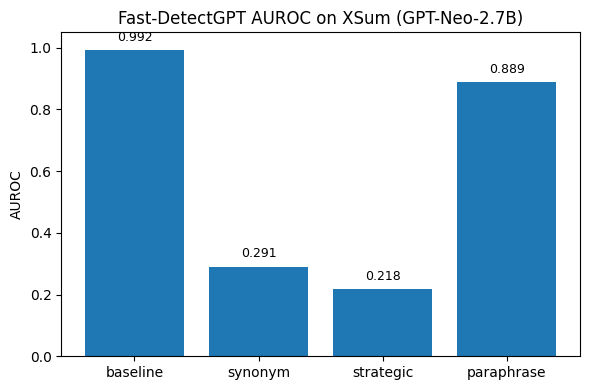

In [33]:
import matplotlib.pyplot as plt

# Prepare data
labels = ["baseline", "synonym", "strategic", "paraphrase"]
aurocs = [baseline_auroc] + [auroc for _, auroc in rows]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, aurocs)

plt.ylim(0, 1.05)
plt.ylabel("AUROC")
plt.title("Fast-DetectGPT AUROC on XSum (GPT-Neo-2.7B)")

# Annotate bars with exact values
for bar, value in zip(bars, aurocs):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{value:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


### Score distributions: histograms of real vs samples

In [34]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_score_histogram(result_file, title=None, bins=40):
    """
    Plot histogram of Fast-DetectGPT scores for real vs samples
    from a single results JSON.
    """
    with open(result_file, "r") as f:
        res = json.load(f)

    real = np.array(res["predictions"]["real"])
    samples = np.array(res["predictions"]["samples"])
    roc_auc = res["metrics"]["roc_auc"]
    n_samples = res["info"]["n_samples"]

    plt.figure(figsize=(6, 4))

    # Real (label 0)
    plt.hist(
        real,
        bins=bins,
        alpha=0.6,
        density=True,
        label=f"Real (mean={real.mean():.2f}, std={real.std():.2f})",
    )

    # Samples (label 1)
    plt.hist(
        samples,
        bins=bins,
        alpha=0.6,
        density=True,
        label=f"Samples (mean={samples.mean():.2f}, std={samples.std():.2f})",
    )

    if title is None:
        title = os.path.basename(result_file)
    plt.title(f"{title}\nAUROC = {roc_auc:.3f}, n={n_samples}")
    plt.xlabel("Fast-DetectGPT score")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


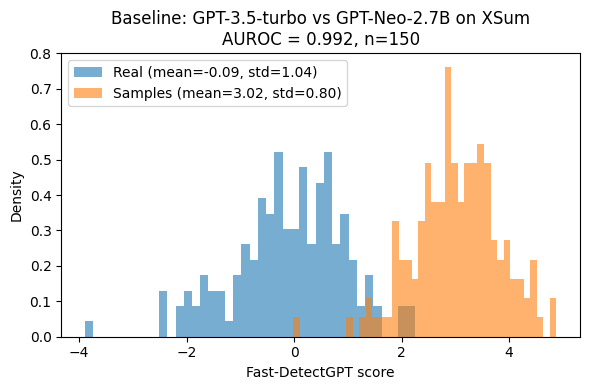

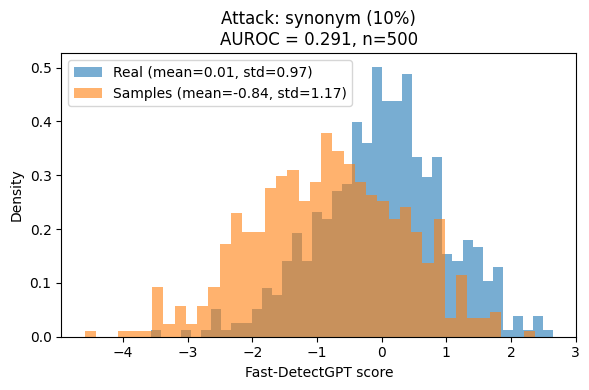

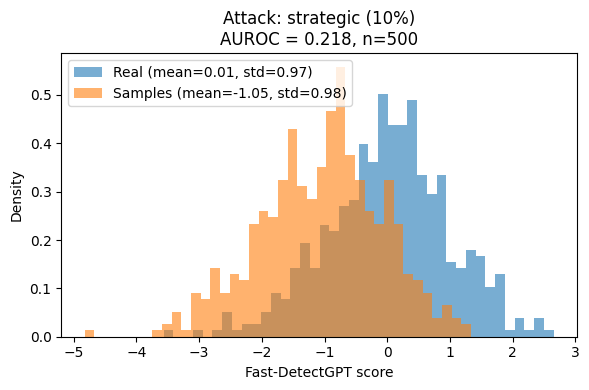

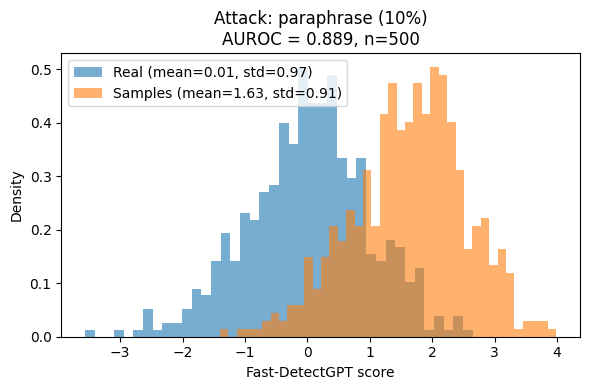

In [35]:
# Baseline
plot_score_histogram(
    baseline_file,
    title="Baseline: GPT-3.5-turbo vs GPT-Neo-2.7B on XSum",
)

# Attacked configs
for attack_name, _ in attack_strategies:
    res_file = (
        f"exp_main/results/"
        f"{dataset}_{source_model}_attacked_{attack_name}_{int(attack_pct * 100)}pct.sampling_discrepancy.json"
    )
    plot_score_histogram(
        res_file,
        title=f"Attack: {attack_name} ({int(attack_pct * 100)}%)",
    )


###